# Build geothermal resource potential suitablity layers for GRIDCERF


The following code was used to build the geothermal resource potential suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.57931/2281697.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  U.S. Enhanced Geothermal Systems (EGS)
- **Description from Source**: This dataset shows the relative favorability of deep Enhanced Geothermal Systems (EGS) in the contiguous United States based on levelized cost of electricity  estimated from adequate temperature and depth combinations.
- **Source URL**:  https://www.nrel.gov/gis/assets/data/egs.zip
- **Date Accessed**:  10/10/23
- **Citation**
> NREL, 2018. U.S. Enhanced Geothermal Systems (EGS). National Renewable Energy Laboratory. https://www.nrel.gov/gis/assets/data/egs.zip (accessed 10/10/23)

**Application**: The class level of the geothermal resource indicates favorability where 1 is the most favorable and 5 is the least favorable for deep enhanced geothermal capability based on temperature and depth combinations. For the GRIDCERF geothermal potential layers, different suitability rasters are built for each of the resource classes 1 through 5, where areas not meeting that resource class are excluded (value = 1). The source data is reprojected to the NAD 1983 Albers contiguous USA (ESRI:102003) coordinate reference system prior to rasterization, no other buffers or modifications are applied.


### 1.3 Import modules


In [1]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [2]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded airport data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'nrel_geothermal_resource_class' )

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile location for the source data
geo_shpfile = os.path.join(source_dir, 'egs', "lower-48-geothermal-high-resolution", "GeothermalLCOE_NoExclusionsforAtlas.shp")

# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'

## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [3]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            #burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            # swap suitability value
            burned = np.where(burned == 1, 0, 1)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [4]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

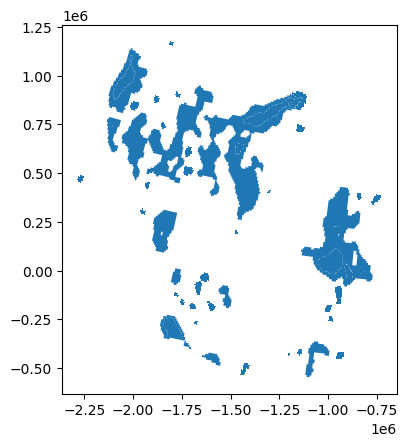

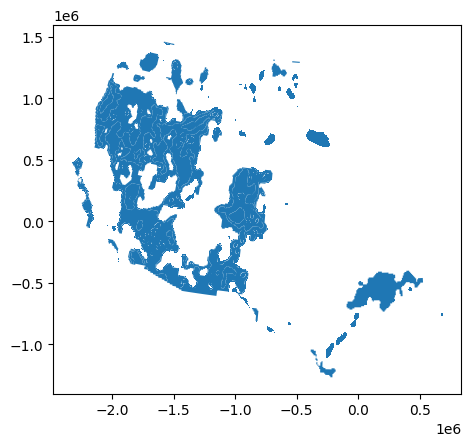

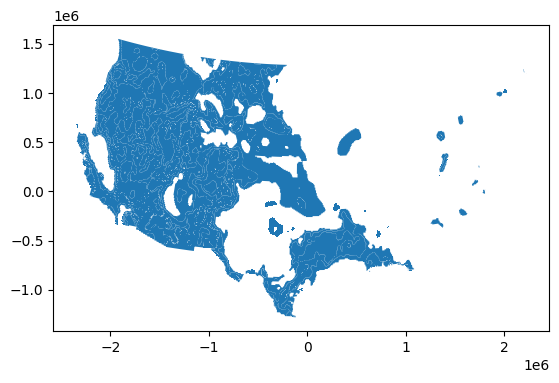

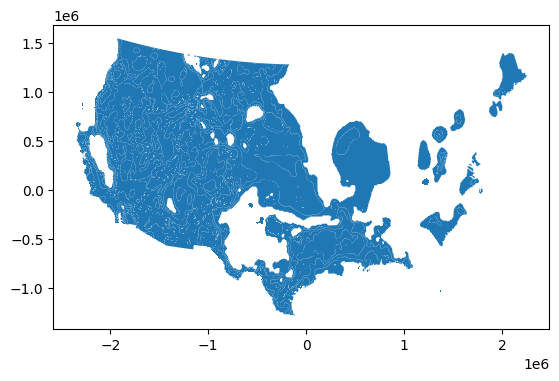

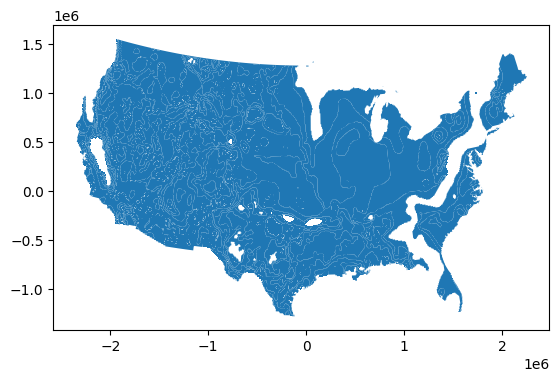

In [5]:
# read in shapefiles and project to our GRIDCERF projection
gdf = gpd.read_file(geo_shpfile).to_crs(crs=crs)

# only keep areas within our GRIDCERF boundary
gdf = gpd.clip(gdf, bdf)

# add field to use for rasterization
gdf["value"] = 1

# drop areas with no geothermal potential
gdf = gdf[gdf.CLASS != 999]

for c in list(range(1, 6, 1)):
    gdf_class = gdf[gdf.CLASS <= c]

    gdf_class.plot()

    # output raster
    output_class_file = os.path.join(technology_specific_dir, f"gridcerf_nrel_geothermal_potential_class{c}_or_greater.tif")

    # generate raster
    vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=gdf_class, 
                 value_field="value",
                 output_raster=output_class_file)